In [252]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
import os
import seaborn as sns
import umap
import csv
import warnings
from collections import OrderedDict
from collections import defaultdict
from scipy import signal, stats
from scipy.linalg import norm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({'figure.max_open_warning': 0})
warnings.simplefilter("ignore")

%run /media/turritopsis/katie/grooming/t1-grooming/grooming_functions.ipynb
%matplotlib inline

sns.set()
sns.set_style('ticks')

In [221]:
# load data
def adjust_rot_angles(angles, angle_names):
    conds = ['2', '3', 'L1A', 'L1B', 'L1C', 'R1A', 'R1B', 'R1C']
    offsets = np.array([-50, -20, 20, -70, 10, 20, 70, -30])
    for j in range(len(conds)):
        rot_angs = [r for r in angle_names if '_rot' in r and conds[j] in r]
        for ang in rot_angs:
            r = np.array(angles[ang])
            r[r > offsets[j]] = r[r > offsets[j]] - 360
            angles[ang] = r
        
    abduct_angs = [r for r in angle_names if '_abduct' in r or 'A_flex' in r]
    for ang in abduct_angs:
        r = np.array(angles[ang])
        r[r > 50] = r[r > 50] - 360
        angles[ang] = r
        
    return angles

prefix = r'/media/turritopsis/pierre/gdrive/latest/behavior/T1_grooming'
data_path = os.path.join(prefix, 'T1_grooming_all.csv.gz')
data = pd.read_csv(data_path, compression = 'gzip')
data['behavior_bout'] = data['T1_grooming_bout_number']
data['flyid'] = data['fly'].astype(str) + ' ' + data['date'].astype(str)
data = data[~data.behavior_bout.isnull()]
data = adjust_bout_numbers(data)
data = remove_short_bouts(data, 60)

angle_names = [v for v in data.columns
              if some_contains(v, ['_flex', '_abduct', '_rot'])
             and v[:2] in ['L1', 'R1']]
data = correct_angles(data, angle_names)
data = adjust_rot_angles(data, angle_names)

In [222]:
angle_vars = [v for v in data.columns
              if some_contains(v, ['_flex', '_rot', '_x', '_y', '_z'])
              and not some_contains(v, ['_d1', '_d2', '_freq', '_range'])
              and v[:2] == 'L1']
features = ['L1B_rot_avg_range', 'L1A_flex_avg_range', 'L1E_z_avg_range', 'L1D_z', 'L1E_z']
flip = [False, False, False, True, True]
data = compute_grooming_scores(data, angle_vars, features, flip = flip, dist=20, norm=False)
data = data[data.grooming_score < 8.25]
data = data[data.grooming_score > 1.6]

bout_numbers = np.unique(np.array(data.behavior_bout))
bout_length_dict = get_bout_lengths(data)
fly_dict = get_fly_id(data, bout_numbers)
videos = get_videos(bout_numbers, data)
fly_videos = fly_to_video(data)
dif_flies = np.unique(list(fly_dict.values()))
fly_data_sorted, fly_names_sorted = data_per_fly(data)

In [365]:
# computes center of mass using the body coxa joints from all six legs 
# and gets the coordinates of the tarsi
def get_positions(data, bc = 'A', weights = None):
    
    joints_x = [x for x in data.columns if bc + '_x' in x and 'range' not in x]
    joints_y = [x for x in data.columns if bc + '_y' in x and 'range' not in x]
    com_x = np.nanmean(data[joints_x], axis = 1)
    com_y = np.nanmean(data[joints_y], axis = 1)
    if weights is not None:
        com_x = np.average(data[joints_x], weights = weights, axis = 1)
        com_y = np.average(data[joints_y], weights = weights, axis = 1)    
    com = np.array([com_x, com_y]).T
    
    tarsi_x = [x for x in data.columns if 'E_x' in x and 'range' not in x]
    tarsi_y = [x for x in data.columns if 'E_y' in x and 'range' not in x]
    xs = np.array(data[tarsi_x])
    ys = np.array(data[tarsi_y])
    
    return xs, ys, com

def get_intersection(com, p1, p2):
    m1 = (p1[1] - p2[1]) / (p1[0] - p2[0])
    m2 = -1/m1
    b1 = p2[1] - m1*p2[0]
    b2 = com[1]-m2*com[0]
    x_int = (b2 - b1) / (m1 - m2)
    y_int = m1*x_int + b1
    point = np.array([x_int, y_int])
    return point

def distance(com, p1, p2):
    dx = p2[0] - p1[0] 
    dy = p2[1] - p1[1]
    num = abs(dy*com[0] - dx*com[1] + p2[0]*p1[1] - p2[1]*p1[0])
    denom = sqrt(pow(dx, 2) + pow(dy,2))
    dist = num / denom
    point = get_intersection(com, p1, p2)
    return dist, point

def get_stability(xs, ys, com, states = np.array([False, True, True, False, True, True])):
    
    static_stability = 0
    point = np.array([np.nan, np.nan])
    idxs = [0, 1, 2, 5, 4, 3]
    xs = xs[idxs]
    ys = ys[idxs]  
    new_states = states[idxs]
    stance_x = xs[new_states]
    stance_y = ys[new_states]
    
    polygon = np.column_stack((stance_x, stance_y))
    path = mpltPath.Path(polygon)
    in_polygon = path.contains_points([com], radius = 1e-9)
    if not in_polygon:
        return static_stability, point
    
    static_stability, point = distance(com, np.array([stance_x[0], stance_y[0]]), np.array([stance_x[-1], stance_y[-1]]))
    if in_polygon:
        for i in range(len(stance_x) - 1):
            dist, p = distance(com, np.array([stance_x[i], stance_y[i]]), np.array([stance_x[i + 1], stance_y[i + 1]]))
            if dist < static_stability: 
                static_stability = dist
                point = p
        
    return static_stability, point

# determines the static stability out of all of the frames 
def get_static_stability(xs, ys, com, states = np.array([False, True, True, False, True, True])):
    n_frames = xs.shape[0]
    static_stability = np.zeros(n_frames)
    points = np.zeros([n_frames, 2])
    for i in range(n_frames): 
        stability, point = get_stability(xs[i, :], ys[i, :], com[i, :], states=states)
        static_stability[i] = stability
        points[i, :] = point
    return static_stability, points

def plot_support_polygon(data, xs, ys, com, point, states = np.array([False, True, True, False, True, True]), legend = False, axes_equal=False):
    
    x_stance = xs[states]
    y_stance = ys[states]
    fig = plt.figure(figsize = (5,5))
    ax = plt.gca()
    ax.set_xlabel('x position', fontsize = 14)
    ax.set_ylabel('y position', fontsize = 14)
    ax.set_title('stability polygon (fly {}, bout {})'.format(str(data.flyid.iloc[0]), str(int(data.behavior_bout.iloc[0]))), fontsize = 14)
    
    plt.scatter(x_stance, y_stance, color = 'k', label = 'stance', zorder = 1)
    plt.scatter(xs[~states], ys[~states], facecolor = 'w', edgecolor = 'k', label = 'swing')
    plt.scatter(com[0], com[1], color = 'b', label = 'center of mass')
    plt.scatter(point[0], point[1], color = 'g')
    plt.plot([point[0], com[0]], [point[1], com[1]], color = 'm', zorder = 0, label = 'static stability')
    plt.plot([x_stance[0], x_stance[1]], [y_stance[0], y_stance[1]], color = 'r', zorder = 0)
    plt.plot([x_stance[1], x_stance[3]], [y_stance[1], y_stance[3]], color = 'r', zorder = 0)
    plt.plot([x_stance[2], x_stance[3]], [y_stance[2], y_stance[3]], color = 'r', zorder = 0)
    plt.plot([x_stance[0], x_stance[2]], [y_stance[0], y_stance[2]], color = 'r', zorder = 0)
    plt.xlim([-1, 1.5])
    plt.ylim([-1.5, 1])
    
    #if axes_equal:
    plt.axes().set_aspect('equal')
    
    if legend:
        hs, ls = ax.get_legend_handles_labels()
        fig = plt.figure(figsize = (3,3))
        plt.legend(handles=hs, loc='center', fontsize = 12)
        plt.axis('off')
        
    sns.despine()
    plt.show()

In [392]:
bc = 'D'
weights = np.array([0.5, 1.0, 1.5, 0.5, 1.0, 1.5])
xs, ys, com = get_positions(data, bc = bc, weights = weights)
static_stability, ps = get_static_stability(xs, ys, com)
data['static_stability'] = static_stability

05272019_fly4_0 R1C23  rot-ccw-0.03 sec


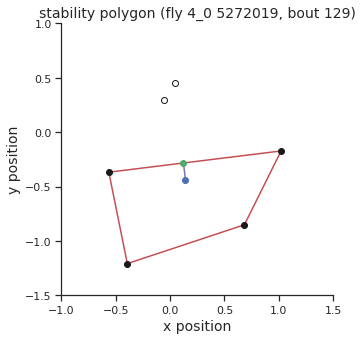

05272019_fly4_0 R3C11  str-ccw-0.09 sec


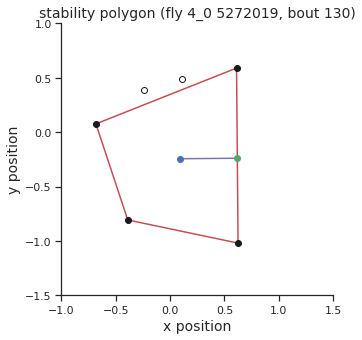

05272019_fly4_0 R3C15  rot-cw-0 sec


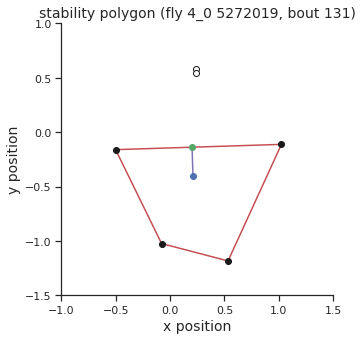

In [396]:
# load data and plot stability for all frames in a bout 
fly_name = '4_0 5272019'
legend = False
plot_all_frames = False
weights = np.array([0.5, 1.0, 1.5, 0.5, 1.0, 1.5])
bc = 'D'
fly_data = data[data.flyid == fly_name]
bout_numbers = np.unique(fly_data.behavior_bout)
for j in range(len(bout_numbers)): 
    bout_data = fly_data[fly_data.behavior_bout == bout_numbers[j]]
    print(bout_data.filename.iloc[0])
    xs, ys, com = get_positions(bout_data, bc = bc, weights = weights)
    static_stability, ps = get_static_stability(xs, ys, com)
    bout_data['static_stability'] = static_stability
    plot_support_polygon(bout_data, xs[0, :], ys[0, :], com[0, :], ps[0, :], legend = legend)
    if plot_all_frames:
        for k in range(len(bout_data)-1):
            plot_support_polygon(bout_data, xs[k+1, :], ys[k+1, :], com[k+1, :], ps[k+1, :], legend = legend, axes_equal = True)

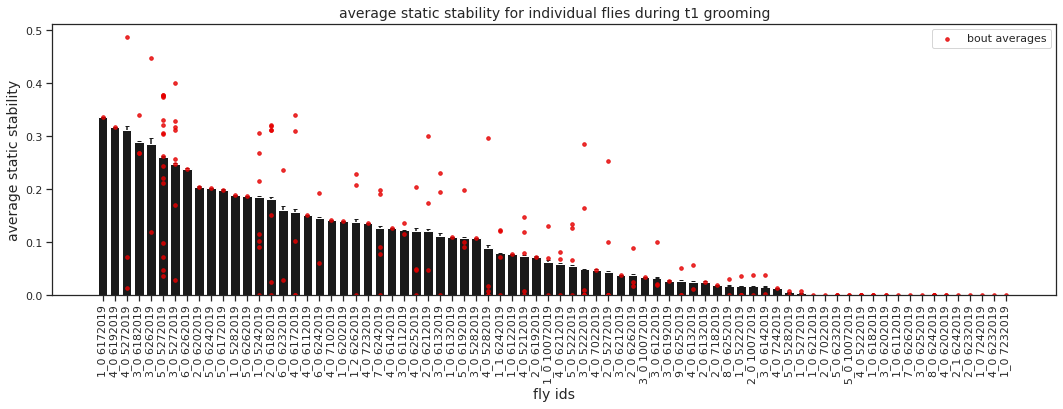

In [390]:
# determine average static stability for each fly, then plot bar graph
fly_names = np.array(list(set(data.flyid)))
ss_avg = np.zeros(len(fly_names))
ss_stderr = np.zeros(len(fly_names))
bout_averages = dict()

for j in range(len(fly_names)):
    
    fly_data = data[data.flyid == fly_names[j]]
    static_stability = fly_data.static_stability
    ss_avg[j] = np.nanmean(static_stability)
    ss_stderr[j] = stats.sem(static_stability, nan_policy = 'omit')
    bout_data = fly_data.groupby(['behavior_bout'], axis = 0).mean()
    bout_averages[fly_names[j]] = np.array(bout_data.static_stability)

sort_idxs = np.argsort(ss_avg)[::-1]
fly_names_sorted = np.take(fly_names, sort_idxs)
ss_sorted = np.take(ss_avg, sort_idxs)
ss_err_sorted = np.take(ss_stderr, sort_idxs)

fig = plt.figure(figsize = (18,5))
ax = plt.gca()
plt.title('average static stability for individual flies during t1 grooming', fontsize = 14) 
plt.xlabel('fly ids', fontsize = 14)
plt.ylabel('average static stability', fontsize = 14)
plt.bar(range(len(fly_names_sorted)), ss_sorted, color = 'k', zorder = 0, alpha = 1)
plt.errorbar(range(len(fly_names_sorted)), ss_sorted, ss_err_sorted, color = 'k', capsize = 2, ls = 'none', zorder = 0)
for j in range(len(fly_names_sorted)):
    bouts = bout_averages[fly_names_sorted[j]]
    plt.scatter([j]*len(bouts), bouts, color = 'xkcd:red', zorder = 1, s = 13, alpha = 0.8, label = 'bout averages' if j == 0 else '')
ax.set_xticks(range(len(fly_names_sorted)))
ax.set_xticklabels(fly_names_sorted, rotation = 90)
plt.legend()
plt.show()